# Notebook 05 - Modélisation des émotions (GoEmotions)

# 1 - Imports & configuration

In [1]:
import os
import sys

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np

from src.utils.tree_utils import afficher_arborescence
from src.pipeline_emotions import run_emotion_pipeline

c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2 - Arborescence du projet

In [2]:
print("📂 Arborescence du projet :")
afficher_arborescence('..', niveau_max = 1)

📂 Arborescence du projet :
├── %USERPROFILE%.git-credentials
├── .coverage
├── .coveragerc
├── .git
│   ├── COMMIT_EDITMSG
│   ├── HEAD
│   ├── config
│   ├── description
│   ├── hooks
│   ├── index
│   ├── info
│   ├── logs
│   ├── objects
│   ├── refs
├── .github
│   ├── workflows
├── .gitignore
├── .pytest_cache
│   ├── .gitignore
│   ├── CACHEDIR.TAG
│   ├── README.md
│   ├── v
├── README.md
├── clean-P9
│   ├── .git
│   ├── .gitignore
│   ├── README.md
│   ├── notebooks
│   ├── requirements.txt
│   ├── src
├── dashboards
├── data
│   ├── processed
│   ├── pytest.ini
│   ├── raw
│   ├── tweets.csv
├── feedback_log_emotions.csv
├── htmlcov
│   ├── .gitignore
│   ├── class_index.html
│   ├── coverage_html_cb_497bf287.js
│   ├── favicon_32_cb_58284776.png
│   ├── function_index.html
│   ├── index.html
│   ├── keybd_closed_cb_ce680311.png
│   ├── status.json
│   ├── style_cb_718ce007.css
│   ├── z_145eef247bfb46b6_data_preprocessing_py.html
│   ├── z_a44f0ac069e85531_test_data_preproce

# 3 - Chargement du dataset GoEmotions

In [3]:
data_path = os.path.join("..", "data", "raw", "goemotions.csv")
df = pd.read_csv(data_path)

print("✅ Dimensions du dataset :", df.shape)
# df.head()

✅ Dimensions du dataset : (211225, 37)


## 3.1 - Création de la colonne "labels" multi-indexée (0 à 27)

In [4]:
emotion_cols = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
    'remorse', 'sadness', 'surprise', 'neutral'
]  # colonnes d’émotions (28 colonnes après les métadonnées)
df['labels'] = df[emotion_cols].apply(lambda row: [i for i, v in enumerate(row) if v == 1], axis=1)

In [5]:
print("✅ Dimensions du dataset :", df.shape)
print("📊 Nombre moyen d’émotions par tweet :", df['labels'].apply(len).mean())
df[['text', 'labels']].head()

✅ Dimensions du dataset : (211225, 38)
📊 Nombre moyen d’émotions par tweet : 1.1813421706710854


,text,labels
0,That game hurt.,[25]
1,>sexuality shouldn’t be a grouping category I...,[]
2,"You do right, if you don't care then fuck 'em!",[27]
3,Man I love reddit.,[18]
4,"[NAME] was nowhere near them, he was by the Fa...",[27]


# 4 - Statistiques de base

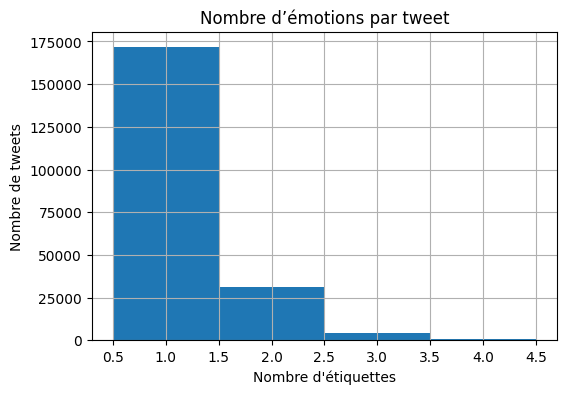

In [6]:
df['n_emotions'] = df['labels'].apply(len)
df['n_emotions'].hist(bins=range(1, 6), align='left', figsize=(6, 4))
plt.title("Nombre d’émotions par tweet")
plt.xlabel("Nombre d'étiquettes")
plt.ylabel("Nombre de tweets")
plt.grid(True)
plt.show()

## 4.1 - Répartition des émotions globales

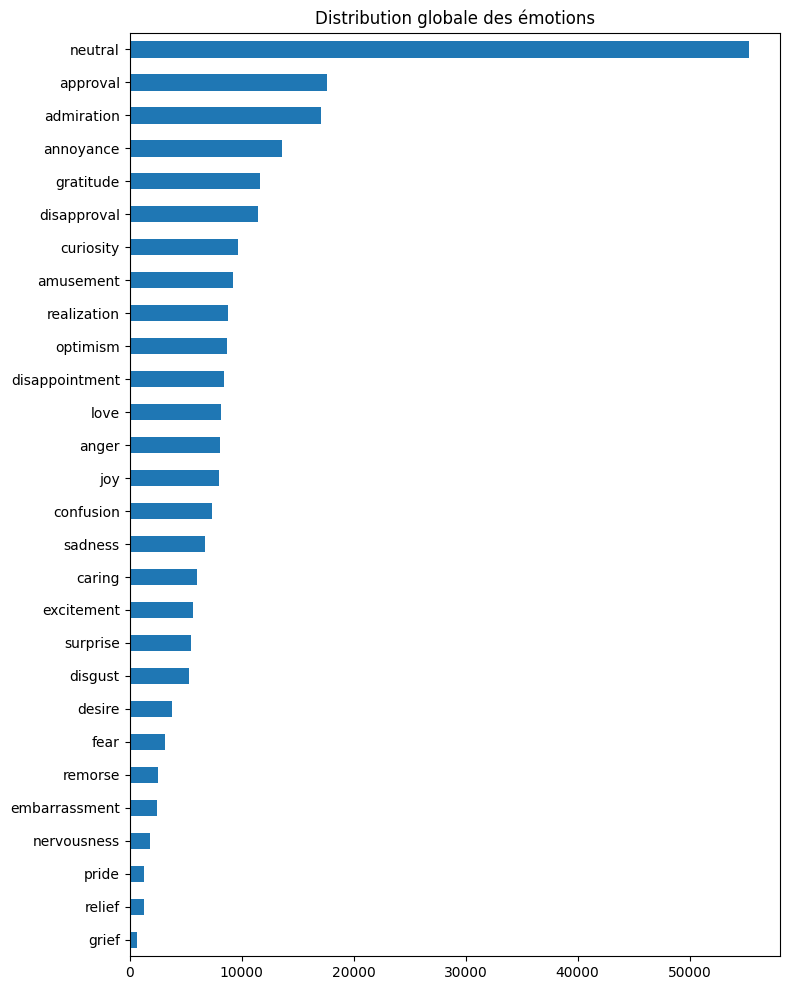

In [7]:
df[emotion_cols].sum().sort_values().plot(kind="barh", figsize=(8, 10))
plt.title("Distribution globale des émotions")
plt.tight_layout()
plt.show()

# 5 - Nuage de mots

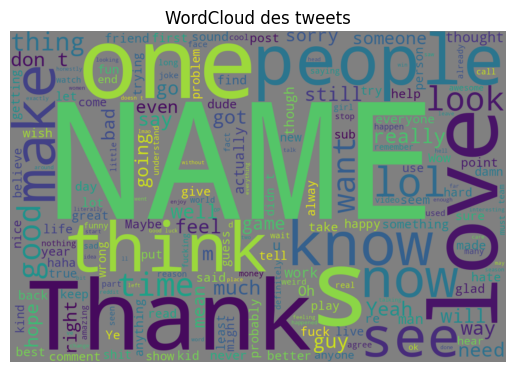

In [8]:
all_text = " ".join(df['text'].tolist())
wordcloud = WordCloud(width = 1200, height = 800, background_color = "grey").generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud des tweets")
plt.show()

# 6 - Entraînement du modèle via pipeline sur GoEmotions (multi-label à 28 classes)

- Entraînement d'un modèle ELECTRA pour la tâche d’analyse fine des émotions à partir du dataset **GoEmotions**, contenant 28 étiquettes émotionnelles (colère, joie, peur, etc.).

    - Contrairement à une tâche de classification binaire, chaque tweet peut ici exprimer **plusieurs émotions simultanément**. Il s'agit donc d'un problème de **classification multi-label**.

---

**Modifications spécifiques apportées au pipeline `run_emotion_pipeline()` :**

- ✅ Chargement du modèle de base `electra-small-discriminator` en local (dossier `models/hf_assets/`)
- ✅ Création dynamique de la colonne `labels` à partir des 28 colonnes d’émotions binaires
- ✅ Initialisation du modèle avec :
  - `num_labels=28` (une sortie par émotion)
  - `problem_type="multi_label_classification"` (Head de classification multi-étiquette)
- ✅ Seuil de prédiction appliqué : `logits > 0 → 1`, sinon `0`
- ✅ Enregistrement automatique :
  - du modèle (`model.save_pretrained(...)`)
  - du tokenizer
  - des métriques (`f1`, `accuracy`) dans `metrics.pkl`
- ✅ Intégration complète à MLflow pour le suivi des runs

---

> Ce modèle est indépendant de celui entraîné pour la classification binaire des sentiments (positif/négatif), et sera enregistré dans `models/emotions/`.

In [9]:
model, tokenizer, metrics = run_emotion_pipeline(force_retrain = False)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\models\hf_assets\electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/92414 [00:00<?, ?it/s]
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'train_runtime': 0.2315, 'train_samples_per_second': 6386547.451, 'train_steps_per_second': 399172.444, 'train_loss': 0.0, 'epoch': 7.0}


100%|██████████| 32/32 [01:12<00:00,  2.27s/it]


# 7 - Résultats & performances

In [10]:
print("\n📈 Résultats d’évaluation du modèle :")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


📈 Résultats d’évaluation du modèle :
eval_loss: 0.3180
eval_f1: 0.3951
eval_accuracy: 0.2600
eval_runtime: 75.1501
eval_samples_per_second: 13.3070
eval_steps_per_second: 0.4260
epoch: 7.0000


### ✅ Résultats du modèle multi-label ELECTRA

Les métriques suivantes ont été calculées sur un sous-échantillon de validation (1000 tweets aléatoires) :

- **F1-score (micro)** : mesure globale de la qualité de prédiction sur les classes actives
- **Accuracy** : proportion de labels exacts prédits (moins informative en multi-label)

---

Ce modèle peut désormais être exploité dans une API ou un dashboard Gradio pour :

- détecter automatiquement plusieurs émotions par tweet
- afficher des graphiques dynamiques d’émotions dominantes
- générer des alertes contextuelles (colère, peur, etc.)

# 8 - Affichage des classes prédites (si applicable)

In [11]:
if "label_distribution" in metrics:
    metrics["label_distribution"].plot(kind = "bar", title = "Distribution des prédictions")
    plt.show()

## 8.1 - Distribution réelle des prédictions sur 2000 tweets

C:\Users\motar\AppData\Local\Temp\ipykernel_18652\1793775309.py:31: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


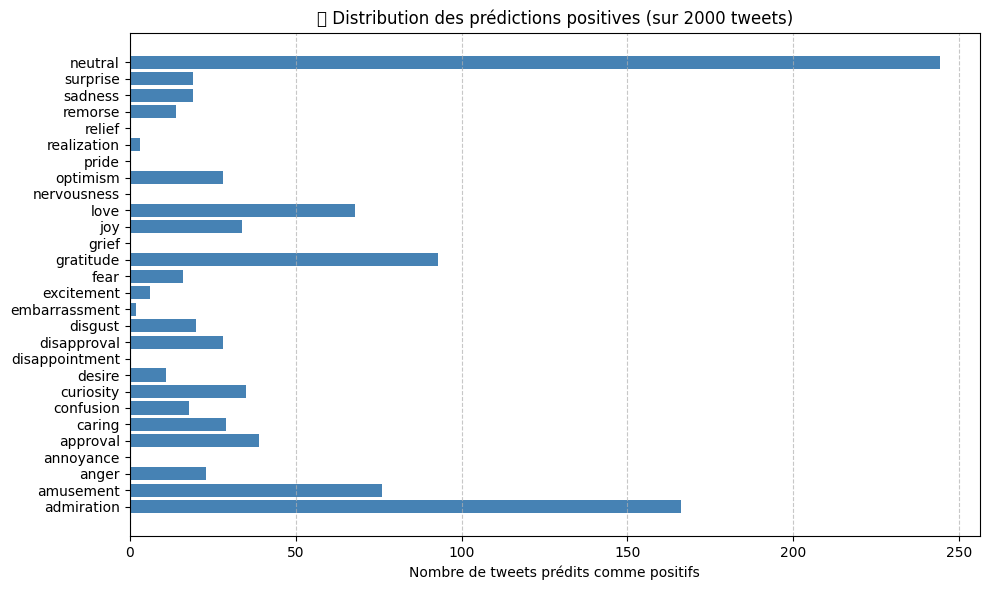

In [15]:
# Rechargement du modèle entraîné (chemin relatif depuis notebooks/)
model = AutoModelForSequenceClassification.from_pretrained("models/emotions/model")
tokenizer = AutoTokenizer.from_pretrained("models/emotions/tokenizer")
model.eval()

# Échantillon de test
df_test = df.sample(n = 2000, random_state = 70).reset_index(drop = True)
texts = df_test["text"].tolist()

# Tokenisation
encodings = tokenizer(texts, truncation = True, padding = True, return_tensors = "pt")

# Prédiction
with torch.no_grad():
    outputs = model(**encodings)

# Conversion logits → prédictions binaires
logits = outputs.logits.detach().numpy()
preds = (logits > 0).astype(int)

# Calcul du total de prédictions positives par émotion
pred_counts = preds.sum(axis=0)

# Affichage
plt.figure(figsize = (10, 6))
plt.barh(range(len(emotion_cols)), pred_counts, color = 'steelblue')
plt.yticks(ticks = range(len(emotion_cols)), labels = emotion_cols)
plt.title("📊 Distribution des prédictions positives (sur 2000 tweets)")
plt.xlabel("Nombre de tweets prédits comme positifs")
plt.grid(axis = "x", linestyle = "--", alpha = 0.7)
plt.tight_layout()
plt.show()

In [16]:
print(f"✔️ Nombre d'émotions dans emotion_cols : {len(emotion_cols)}")
print(f"✔️ Nombre de colonnes dans les prédictions : {pred_counts.shape}")

✔️ Nombre d'émotions dans emotion_cols : 28
✔️ Nombre de colonnes dans les prédictions : (28,)


## 8.2 - Comparaison VRAI vs PRÉDIT (2000 tweets)

C:\Users\motar\AppData\Local\Temp\ipykernel_18652\4263936731.py:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


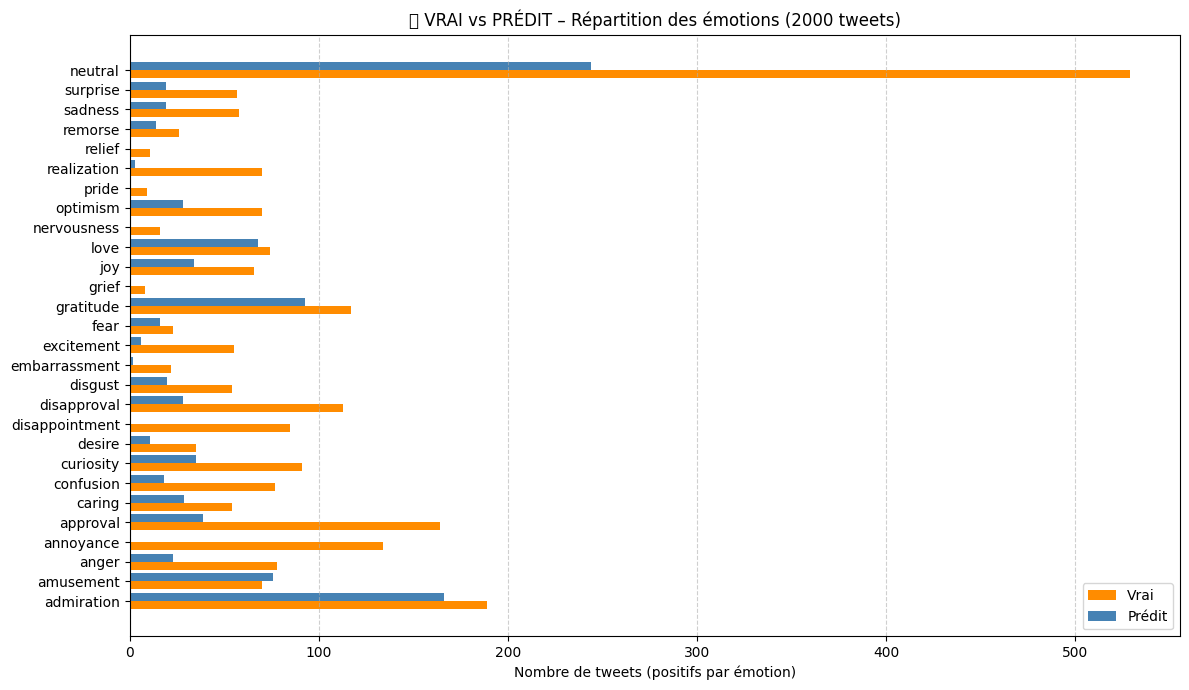

In [17]:
# Répartition réelle (ground truth)
true_counts = df_test[emotion_cols].sum().values

# Répartition des prédictions (déjà calculée précédemment)
pred_counts = preds.sum(axis=0)  # ← déjà défini

# Affichage comparatif
x = np.arange(len(emotion_cols))  # positions
width = 0.4

plt.figure(figsize=(12, 7))
plt.barh(x - width/2, true_counts, height=width, label='Vrai', color='darkorange')
plt.barh(x + width/2, pred_counts, height=width, label='Prédit', color='steelblue')

plt.yticks(ticks=x, labels=emotion_cols)
plt.xlabel("Nombre de tweets (positifs par émotion)")
plt.title("📊 VRAI vs PRÉDIT – Répartition des émotions (2000 tweets)")
plt.legend(loc="lower right")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## 8.3 - Heatmap de co-occurrence des émotions prédites

C:\Users\motar\AppData\Local\Temp\ipykernel_18652\1794568889.py:11: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout()
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


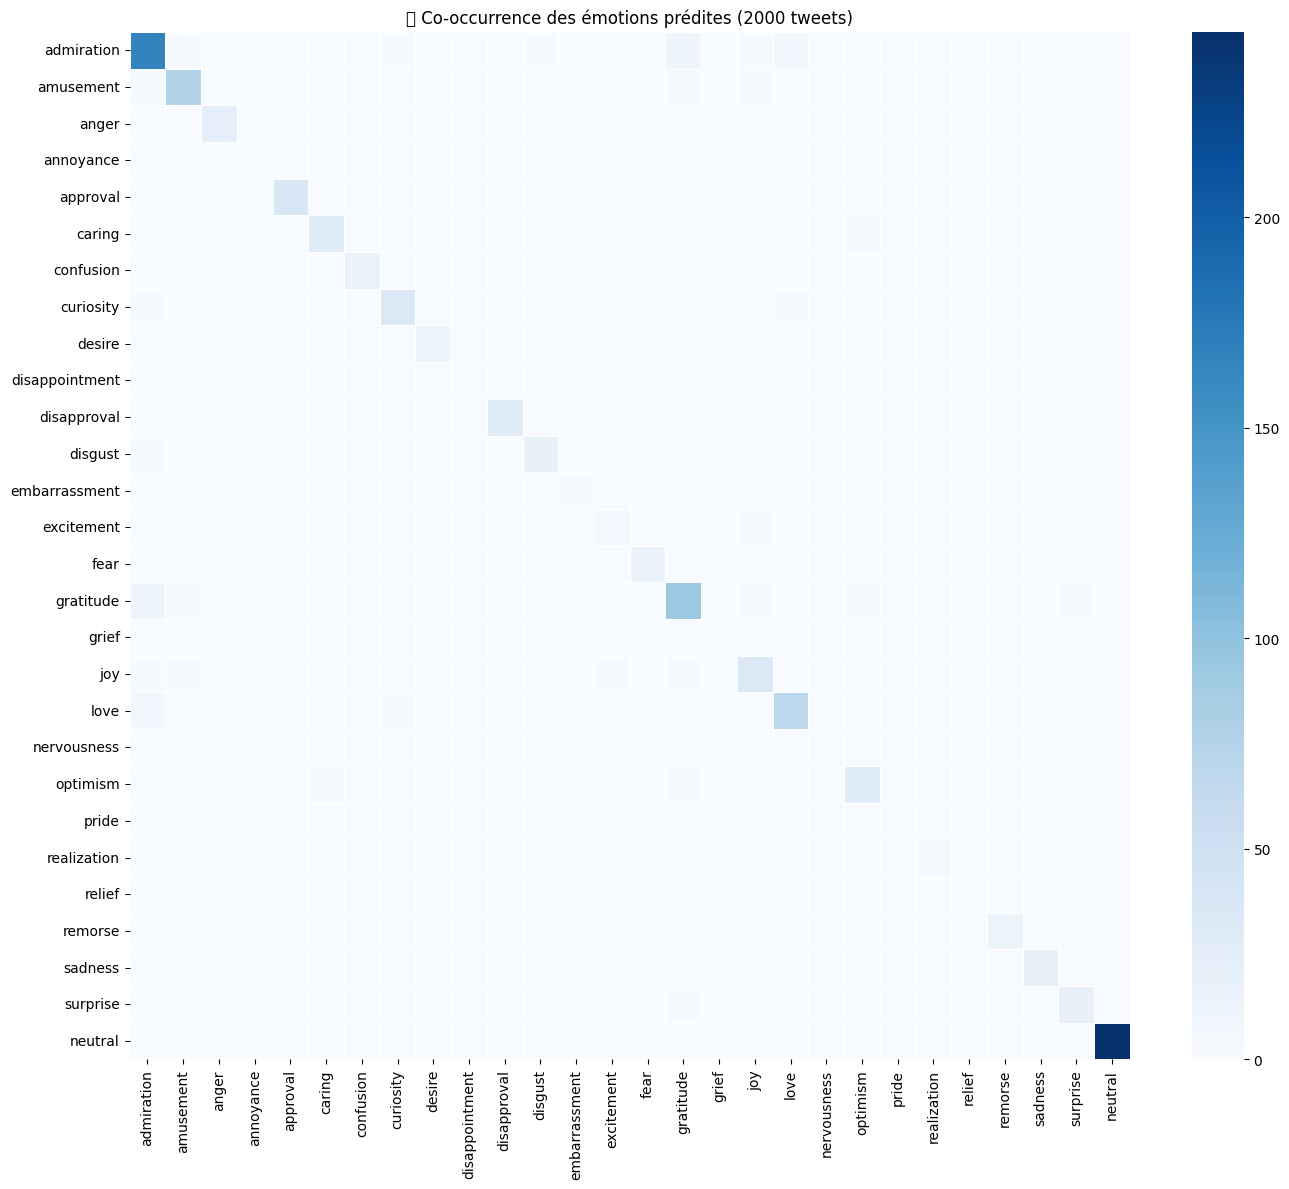

In [18]:
# Création d’une DataFrame des prédictions binaires (2000 tweets × 28 émotions)
pred_df = pd.DataFrame(preds, columns  =emotion_cols)

# Matrice de co-occurrence (corrélation binaire entre émotions)
co_matrix = pred_df.T.dot(pred_df)

# Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(co_matrix, xticklabels=emotion_cols, yticklabels=emotion_cols, cmap="Blues", linewidths=0.5)
plt.title("🔥 Co-occurrence des émotions prédites (2000 tweets)")
plt.tight_layout()
plt.show()

## 8.4 - Export CSV des stats d’émotions par label

In [19]:
stats_df = pd.DataFrame({
    "emotion": emotion_cols,
    "true_count": true_counts,
    "pred_count": pred_counts,
    "difference": pred_counts - true_counts,
    "abs_error": np.abs(pred_counts - true_counts)
})

stats_df.sort_values(by="abs_error", ascending=False, inplace=True)
export_path = os.path.join("..", "outputs", "emotion_stats_2000.csv")
os.makedirs(os.path.dirname(export_path), exist_ok=True)
stats_df.to_csv(export_path, index=False, encoding="utf-8")

print(f"📁 Statistiques exportées avec succès dans : {export_path}")
display(stats_df.head(10))

📁 Statistiques exportées avec succès dans : ..\outputs\emotion_stats_2000.csv


,emotion,true_count,pred_count,difference,abs_error
27,neutral,529,244,-285,285
3,annoyance,134,0,-134,134
4,approval,164,39,-125,125
10,disapproval,113,28,-85,85
9,disappointment,85,0,-85,85
22,realization,70,3,-67,67
6,confusion,77,18,-59,59
7,curiosity,91,35,-56,56
2,anger,78,23,-55,55
13,excitement,55,6,-49,49


# 9 - Vérification des artefacts

In [20]:
print("\n🗂️ Modèles enregistrés :")
afficher_arborescence("models/emotions", niveau_max = 2)


🗂️ Modèles enregistrés :
├── checkpoint-79212
│   ├── config.json
│   ├── model.safetensors
│   ├── optimizer.pt
│   ├── rng_state.pth
│   ├── scheduler.pt
│   ├── special_tokens_map.json
│   ├── tokenizer.json
│   ├── tokenizer_config.json
│   ├── trainer_state.json
│   ├── training_args.bin
│   ├── vocab.txt
├── checkpoint-92414
│   ├── config.json
│   ├── model.safetensors
│   ├── optimizer.pt
│   ├── rng_state.pth
│   ├── scheduler.pt
│   ├── special_tokens_map.json
│   ├── tokenizer.json
│   ├── tokenizer_config.json
│   ├── trainer_state.json
│   ├── training_args.bin
│   ├── vocab.txt
├── logs
│   ├── events.out.tfevents.1746978163.PC-ARNAUD.13144.0
│   ├── events.out.tfevents.1746978485.PC-ARNAUD.26512.0
│   ├── events.out.tfevents.1746978666.PC-ARNAUD.4760.0
│   ├── events.out.tfevents.1746994927.PC-ARNAUD.4760.1
│   ├── events.out.tfevents.1746997802.PC-ARNAUD.30124.0
│   ├── events.out.tfevents.1747035152.PC-ARNAUD.30124.1
│   ├── events.out.tfevents.1747036724.PC-ARNAUD.30

## 9.1 - Interface de tracking MLflow (http://localhost:5000)

In [21]:
import subprocess

try:
    subprocess.Popen(["mlflow", "ui"])
    print("✅ MLflow UI lancé sur http://localhost:5000")
except Exception as e:
    print(f"❌ Impossible de lancer MLflow UI : {e}")

✅ MLflow UI lancé sur http://localhost:5000


In [ ]:
import os
import mlflow

# 🔧 Spécifie l'URI local
mlruns_path = os.path.abspath("../mlruns").replace("\\", "/")
mlflow.set_tracking_uri(f"file:///{mlruns_path}")

# 🔍 Recherche du modèle enregistré
client = mlflow.MlflowClient()
model_name = "emotions_classifier"

try:
    model = client.get_registered_model(model_name)
    print(f"✅ Modèle {model.name} trouvé avec {len(model.latest_versions)} version(s)")

    for version in model.latest_versions:
        print("📦 Version:", version.version)
        print("🔁 Run ID :", version.run_id)
        print("📂 Source :", version.source)
        print("-" * 30)

except Exception as e:
    print(f"❌ Erreur : {e}")

✅ Modèle emotions_classifier trouvé avec 3 version(s)
📦 Version: 1
🔁 Run ID : d28ed191e37a4761971a3332f9ff0a29
📂 Source : file:///C:/Users/motar/Desktop/1-openclassrooms/AI_Engineer/1-projets/P09/P9_V2/mlruns/0/d28ed191e37a4761971a3332f9ff0a29/artifacts/emotions_model
------------------------------
📦 Version: 2
🔁 Run ID : 2a4098924208444baa1d3cffcc3abb70
📂 Source : file:///C:/Users/motar/Desktop/1-openclassrooms/AI_Engineer/1-projets/P09/P9_V2/mlruns/0/2a4098924208444baa1d3cffcc3abb70/artifacts/emotions_model
------------------------------
📦 Version: 3
🔁 Run ID : 4589d8f9e2514c11866d287cc1c506ce
📂 Source : file:///C:/Users/motar/Desktop/1-openclassrooms/AI_Engineer/1-projets/P09/P9_V2/mlruns/0/4589d8f9e2514c11866d287cc1c506ce/artifacts/emotions_model
------------------------------


: 

# Lien vers l'application (ngrok) :
# https://f22e-2a01-cb1d-8598-1400-4ac7-ab2e-4237-81aa.ngrok-free.app